Raster files are a common data format used in remote sensing to represent spatial information as a grid of cells. Each cell contains a single value representing a certain attribute, such as elevation, temperature, or land cover type.

Raster files are composed of one or more bands, where each band represents a different type of information or measurement. For example, in satellite imagery, different bands may capture data from different parts of the electromagnetic spectrum, such as different wavelengths of visible light or even infrared.

To illustrate these concepts, we will use a raster image obtained from [NASA Worldview Snapshots](https://wvs.earthdata.nasa.gov/) that encode some of the most popular bands of the Terra and Aqua Moderate Resolution Imaging Spectroradiometer (MODIS) satellite into the red, green, and blue bands. Each combination of bands is designed to highlight specific atmospheric (e.g. clouds) and landscape (e.g. vegetation, water bodies) features.

### MODIS Bands 7-2-1

Band 7 = 2155 nm
Band 2 = 876 nm
Band 1 = 670 nm

- Vegetation appears green. Vegetation is very reflective in Band 2 (reason why it was assigned to the green channel)
- Liquid water: Black or dark blue
- Desert/Naturally bare soil: Sandy pink
- Burn scar: Red to reddish-brown
- Snow and ice are very reflective in band 7
- Ice and snow appear as bright turquoise. 
- Clouds appear white. 


>To install **rasterio** you can run one of these two commands in the terminal or command window: `pip install rasterio` or `conda install rasterio`


In [171]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask


In [172]:
# Load geo-referenced .TIF image
raster = rasterio.open('../datasets/spatial/Terra-MODIS-7-2-1-2019-09-05.tiff')


## Coordinate systems

A coordinate reference system (CRS) is a local, regional or global system used to locate geographical entities. Spatial reference systems can be referred including EPSG codes defined by the International Association of Oil and Gas Producers. The EPSG acronym stands for *European Petroleum Survey Group* and is an organization that maintains a geodetic parameter database with standard codes.

[EPSG:4326](https://epsg.io/4326) is equal to WGS84 - World Geodetic System 1984


In [173]:
# Print the coordinate reference system
print(raster.crs)


EPSG:4326


## Band properties

It is always useful to explore the number of bands in a raster, the data type, and dimensions of each band. The `nodata` and `nodatavals` indicate how the dataset encodes missing values or values outside a specific regions (e.g. pixels that fall on the ocean).

In [174]:
# Print band attributes
print('Data type:', raster.dtypes)
print('Band width (number columns):', raster.width)
print('Band height (number of rows):', raster.height)
print('Band indexes:', raster.indexes)
print('No data placeholder:',raster.nodatavals)


Data type: ('uint8', 'uint8', 'uint8')
Band width (number columns): 2877
Band height (number of rows): 1602
Band indexes: (1, 2, 3)
No data placeholder: (None, None, None)


## Raster bounding box
Another important attribute to have at hand is the bounding box. This information gives us a precise idea of the limits of the map and also shows whther we are working in geographic or projected coordinates.

In [175]:
# Find map boundaries
print(raster.bounds)


BoundingBox(left=-102.30474587359757, bottom=36.73867052309612, right=-94.22721987359756, top=40.25910252309606)


## Raster pixel to geographic coordinates

An easy way to access the pixel coordiantes given the row and column of the raster. The `offset` allow us to specify the starting point. Selecting the **Upper-Left** corner makes things easy because that is also the beginning of the raster array in terms of rows and columns. So, if we request the geographic coordinates of `row=0` and `column=0` with `offset='ul'`, we should obtain the coordinates of the top-left corner of the boundaing box.


In [176]:
# Get geographic coordinate for specific row and column.
raster.xy(row=0, col=0, offset='ul') # center by default. ul, ur, ll, lr.


(-102.30474587359757, 40.25910252309606)

In [177]:
# Another example
raster.xy(row=60, col=1200, offset='ul') # center by default. ul, ur, ll, lr.


(-98.93560051384783, 40.12725113732827)

## Explore raster bands

To specify a particular band we will pass a tuple as the first input argument of the rasterio show command `(raster, 1)`. The index must be one of the indexes in the raster. Hopefully now you see why accessing some of the basic raster attributes in the previous cells becomes handy now.


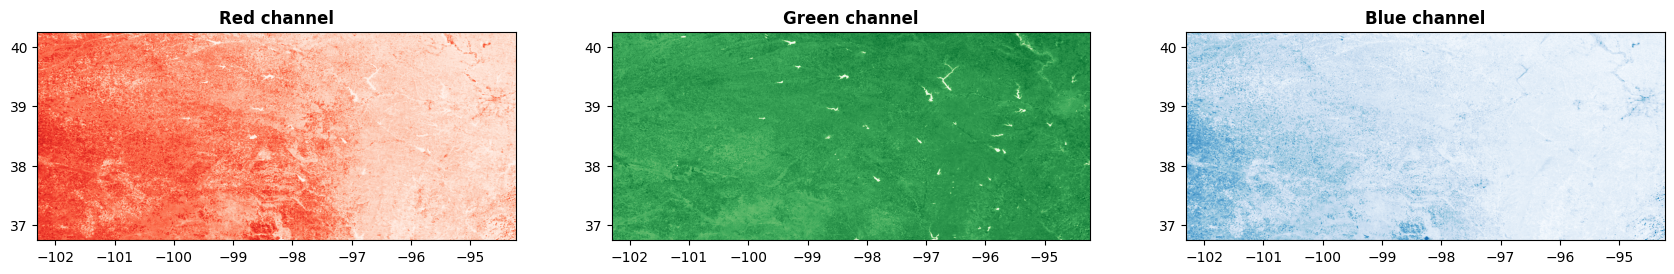

In [178]:
# Display individual bands
fig, (ax_red, ax_green, ax_blue) = plt.subplots(1,3, figsize=(21,7))
show((raster, 1), ax=ax_red, cmap='Reds', title='Red channel')
show((raster, 2), ax=ax_green, cmap='Greens', title='Green channel')
show((raster, 3), ax=ax_blue, cmap='Blues', title='Blue channel')
plt.show()


## Bands combined as a single image
When we combine all three bands in the red, green, and blue channels we can obtain a new composite image.


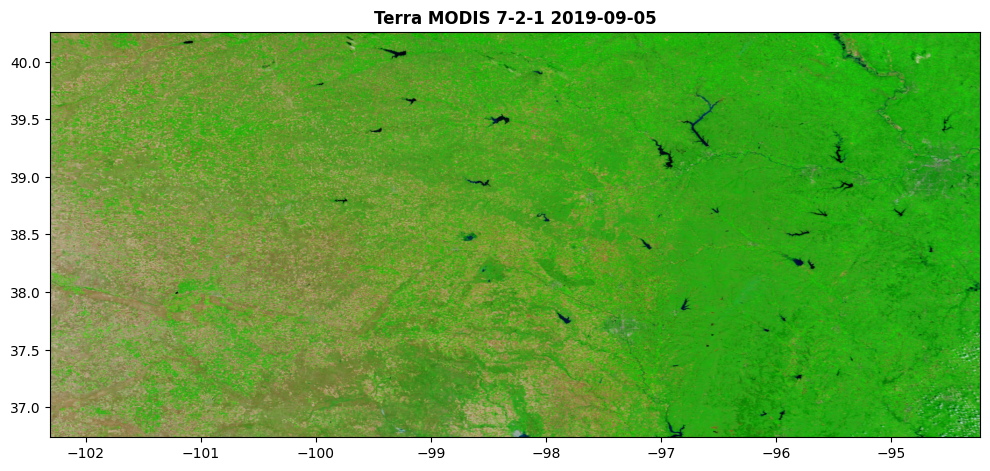

In [179]:
plt.figure(figsize=(12,8))
show(raster, title='Terra MODIS 7-2-1 2019-09-05')
plt.show()


The image was taken on 5-September-2019, a time of the year where much of the warm-season grasses, pastures, and crops still remain verdant. Only few early planted warm-season crops were probably harvested by this date. Areas that appear yellow or brownish are likely to be places without vegetation (e.g. urban areas, barren land) or fields that had a winter crop, which by this time will consists of fallow land with bare soil or stubble.


## Retrive bands from a specific point

Imagine we are interested in knowing the information for the different bands at a specific point in the map. The `index()` method can help us retrieving this information by providing us with the row and column of a specific pair of geographic coordinates.

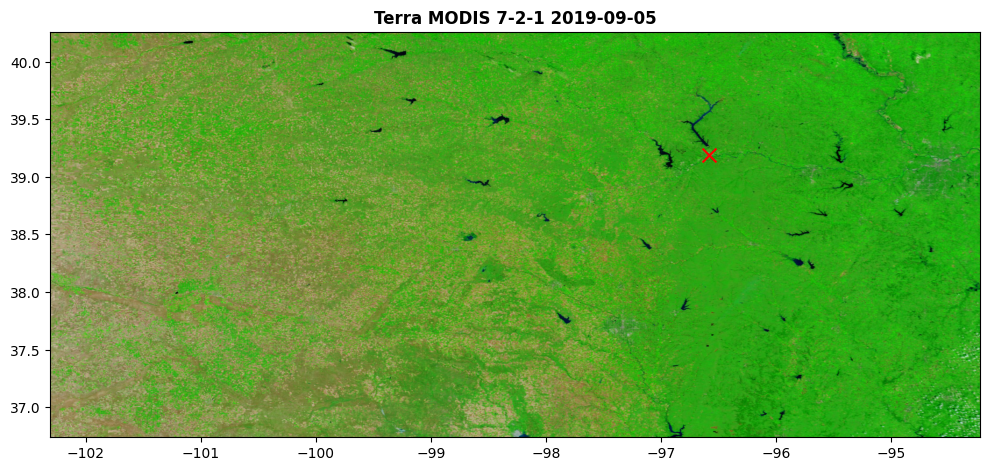

In [180]:
# Add location to map
mhk_lat = 39.193608
mhk_lon = -96.584593

plt.figure(figsize=(12,8))
plt.scatter(mhk_lon, mhk_lat, marker='x', color='r', s=100) # this line needs to precede the raster.
show(raster, title='Terra MODIS 7-2-1 2019-09-05')
plt.show()


In [181]:
# Retrieve RGB values for specified location
py,px = raster.index(mhk_lon, mhk_lat)
print('Row =',py, 'Col=',px)
mhk_red = raster.read(1)[py,px]
mhk_green = raster.read(2)[py,px]
mhk_blue = raster.read(3)[py,px]

print('R=',mhk_red, 'G=',mhk_green, 'B=',mhk_blue)


Row = 484 Col= 2037
R= 86 G= 142 B= 58


All three RGB values can be obtained with a single statement: `raster.read()[:,py,px]`

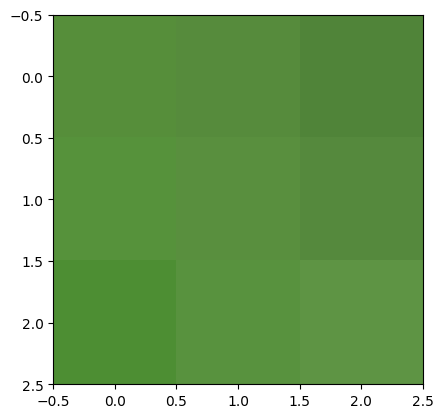

In [182]:
# Get a small area around selected point
mhk_pixel = raster.read(window=rasterio.windows.Window(px,py,3,3))

# Display window
show(mhk_pixel);

In [183]:
# Create an NxN window
N = 100
window = rasterio.windows.Window(px-N//2, py-N//2, N, N)
print(window)


Window(col_off=1987, row_off=434, width=100, height=100)


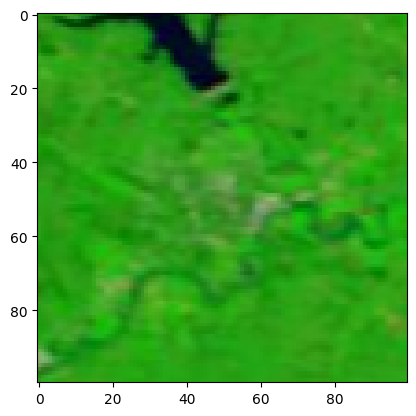

In [184]:
# Read the data in the window
clip = raster.read(window=window)

# Display window
show(clip);


## East-West transect

The state of Kansas spans an accentuated longitudinal precipitation gradient. The West par tof the state receives nearly 400 mm per year, while the east portion of the state receives nearly 1200 mm per year.
o
We can visualize whether vegetationlso follows a similar patterns by plot one (or perhaps) rows.

In [185]:
# Select a particular latitude
selected_lat = 38.6
py,px = raster.index(-102, selected_lat)
selected_row = py
row_values = np.ones(raster.shape[1]) * selected_row
col_values = np.arange(raster.shape[1])

lon_EW = raster.xy(row=row_values, col=col_values, offset='ul');


In [186]:
# Excess green
R = np.float64(raster.read(1))
G = np.float64(raster.read(2))
B = np.float64(raster.read(3))

ExG = 2*G - R - B

# Get Excess green for selected row
ExG_row = ExG[selected_row,:]


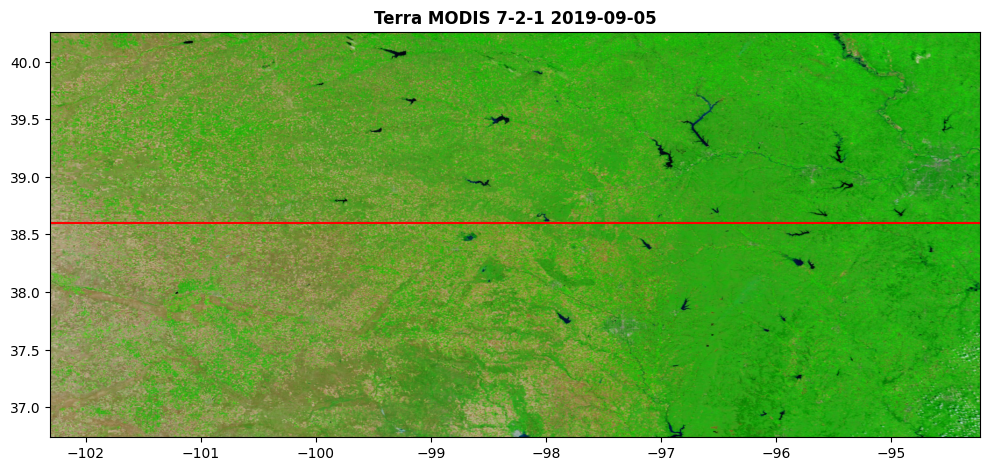

In [187]:
# Show row in map
plt.figure(figsize=(12,8))
plt.axhline(selected_lat, color='r')
show(raster, title='Terra MODIS 7-2-1 2019-09-05')
plt.show()


In [188]:
# Smooth signal to eliminate small interferences in the landscape
from scipy.signal import medfilt
ExG_row = medfilt(ExG_row, kernel_size=21)


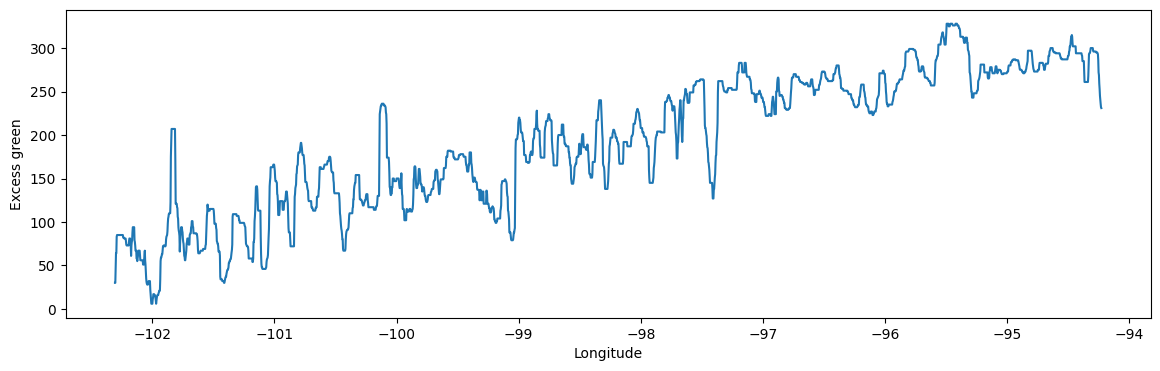

In [189]:
# Plot East-West transect across Kansas
plt.figure(figsize=(14,4))
plt.plot(lon_EW[0], ExG_row)
plt.xlabel('Longitude')
plt.ylabel('Excess green') # Indicator of greenness
plt.show()


As expected, we can see a clear trend of increasing vegetation greenness from West to East.The signal is a bit noisy, meaning that there are some fields in western Kansas that are green (probably agricultural fields under irrigation, or rainfed fields that received good rainfall). Our transect also goes over rivers, small water bodies, and perhaps urban areas, casuing some ups and downs in the signal. The median filter should be able to remove some of this noise. You can try different kernel sizes to be more or less aggressive with the filter.


## Use GeoPandas to clip area

In this case we will use a polygon to clip a portion of the raster map.

In [190]:
# Import additional modules
import geopandas as gpd


In [191]:
# Read boundary of Riley county, KS
counties = gpd.read_file('../datasets/spatial/us_county_5m.geojson')

# Select Riley county
idx = counties['NAME'] == 'Geary'
county = counties[idx]


In [192]:
# Clip the raster to the polygon extent
clipped_raster, clipped_transform = mask(raster, county.geometry, crop=True)

# Inspect dimensions of clipped raster
print(clipped_raster.shape)

# Note that Rasterio places the number of bands in the first axis

(3, 161, 166)


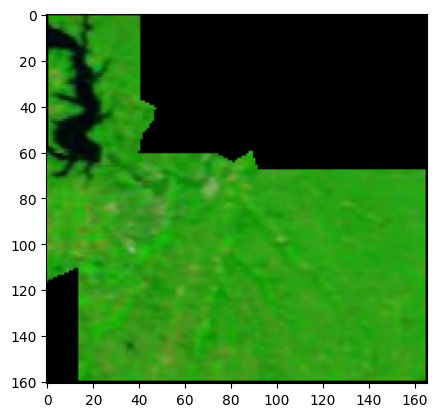

In [193]:
# Show clipped raster image
show(clipped_raster)
plt.show()

In [194]:
# Set background of pixels as white

# Get the clipped raster as a numpy array
clipped_raster = clipped_raster.transpose(1, 2, 0)

# Replace nodata values with 255 (white)
idx_mask = np.sum(clipped_raster, axis=2)==0
clipped_raster[idx_mask,:] = 255


In [195]:
# Restore order of dimensions 
clipped_raster = clipped_raster.transpose(2, 0, 1)
print(clipped_raster.shape)


(3, 161, 166)


In [196]:
# Update metadata of clipped raster
new_metadata = raster.meta.copy()
new_metadata.update({
    'height': clipped_raster.shape[1],
    'width': clipped_raster.shape[2],
    'transform': clipped_transform
})


# Save the clipped raster to a new file
clipped_raster_filename = '../datasets/spatial/county_ks_vegetation.tif'
with rasterio.open(clipped_raster_filename, 'w', **new_metadata) as f:
    f.write(clipped_raster)
    

In [197]:
# Read saved clipped raster
clipped_raster = rasterio.open(clipped_raster_filename)


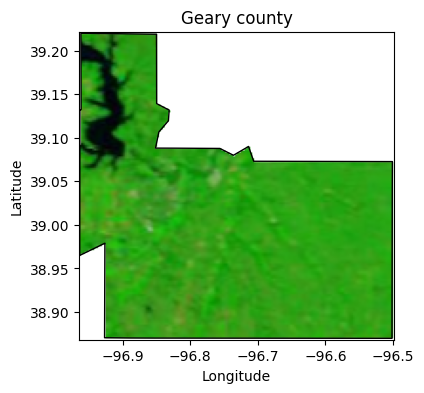

In [198]:
# Show clipped raster

fig,ax = plt.subplots(figsize=(5,4))
show(clipped_raster, ax=ax)
county.plot(ax=ax, facecolor='None', edgecolor='k')
plt.title('Geary county')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
